# Exploratory Data Analysis (EDA) - togo-dapaong_qc Dataset
This notebook performs EDA: summary statistics, missing-value analysis, outlier detection, and basic cleaning.

In [1]:
# Import EDAAnalyzer and basic libraries
import sys
import os

# Ensure project root is in sys.path for module imports
sys.path.insert(0, os.path.abspath('..'))
from scripts.eda_analyzer import EDAAnalyzer
import pandas as pd
import numpy as np
from scipy import stats


In [2]:
# Instantiate analyzer for Togo dataset with error handling
try:
    analyzer = EDAAnalyzer(
        csv_path='../src/data/togo-dapaong_qc.csv',
        country_key='togo-dapaong_qc'
    )
    df = analyzer.load_data()  # Load data into DataFrame
    display(df.head())
except Exception as e:
    print(f"Error initializing EDAAnalyzer or loading Togo data: {e}")
    df = pd.DataFrame()

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-10-25 00:01:00,-1.3,0.0,0.0,0.0,0.0,24.8,94.5,0.9,1.1,0.4,227.6,1.1,977,0,0.0,24.7,24.4,NaN
1,2021-10-25 00:02:00,-1.3,0.0,0.0,0.0,0.0,24.8,94.4,1.1,1.6,0.4,229.3,0.7,977,0,0.0,24.7,24.4,NaN
2,2021-10-25 00:03:00,-1.3,0.0,0.0,0.0,0.0,24.8,94.4,1.2,1.4,0.3,228.5,2.9,977,0,0.0,24.7,24.4,NaN
3,2021-10-25 00:04:00,-1.2,0.0,0.0,0.0,0.0,24.8,94.3,1.2,1.6,0.3,229.1,4.6,977,0,0.0,24.7,24.4,NaN
4,2021-10-25 00:05:00,-1.2,0.0,0.0,0.0,0.0,24.8,94.0,1.3,1.6,0.4,227.5,1.6,977,0,0.0,24.7,24.4,NaN


In [3]:
# Profile the data: summary statistics & missing-value report
summary_stats, missing_report = analyzer.profile()
print('=== Summary Statistics ===')
print(summary_stats)

print('=== Missing-Value Report ===')
print(missing_report)

# Identify columns with >5% missing values
high_missing = missing_report[missing_report['missing_pct'] > 5].index.tolist()
print('Columns with >5% missing:', high_missing)

=== Summary Statistics ===
                           Timestamp            GHI            DNI  \
count                         525600  525600.000000  525600.000000   
mean   2022-04-25 12:00:30.000000768     230.555040     151.258469   
min              2021-10-25 00:01:00     -12.700000       0.000000   
25%              2022-01-24 06:00:45      -2.200000       0.000000   
50%              2022-04-25 12:00:30       2.100000       0.000000   
75%              2022-07-25 18:00:15     442.400000     246.400000   
max              2022-10-25 00:00:00    1424.000000    1004.500000   
std                              NaN     322.532347     250.956962   

                 DHI           ModA           ModB           Tamb  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      116.444352     226.144375     219.568588      27.751788   
min         0.000000       0.000000       0.000000      14.900000   
25%         0.000000       0.000000       0.000000      24.200000 

### Summary Statistics & Missing-Value Report


### Outlier Detection & Basic Cleaning


In [4]:
COUNTRY         = "togo-dapaong_qc"             # used for naming the output file
OUTLIER_THRESH  = 3.0                    # Z-score threshold
DROP_OUTLIERS   = False                  # set True to remove flagged rows

# Export the cleaned dataset to CSV
analyzer.export()


Data exported to: data/togo-dapaong_qc_clean.csv


In [5]:
# 3. Columns to analyze
sensor_cols = ["GHI", "DNI", "DHI", "ModA", "ModB", "WS", "WSgust"]

# 4. Compute medians for imputation and fillna for Z-score calc
medians = df[sensor_cols].median()
filled_for_z = df[sensor_cols].fillna(medians)



In [6]:
# Compute Z-scores and flag outliers
z_scores = stats.zscore(filled_for_z)
abs_z    = pd.DataFrame(abs(z_scores), columns=sensor_cols, index=df.index)
df["is_outlier"] = abs_z.gt(OUTLIER_THRESH).any(axis=1)

print(f"Flagged {df['is_outlier'].sum()} outliers out of {len(df)} total rows.")


Flagged 9251 outliers out of 525600 total rows.


In [7]:
# 6. Impute missing values (median) without chained assignment
for col in sensor_cols:
    df[col] = df[col].fillna(medians[col])



In [8]:

# 8. Export cleaned data
os.makedirs("data", exist_ok=True)
out_path = f"data/{COUNTRY}_clean.csv"
df.to_csv(out_path, index=False)
print(f"Cleaned data written to: {out_path}")


Cleaned data written to: data/togo-dapaong_qc_clean.csv


### Time series Analysis

In [9]:
import matplotlib.pyplot as plt


In [10]:
CLEAN_PATH = "data/togo-dapaong_qc_clean.csv" 


In [11]:
df = pd.read_csv(CLEAN_PATH, parse_dates=["Timestamp"])
df = df.sort_values("Timestamp")



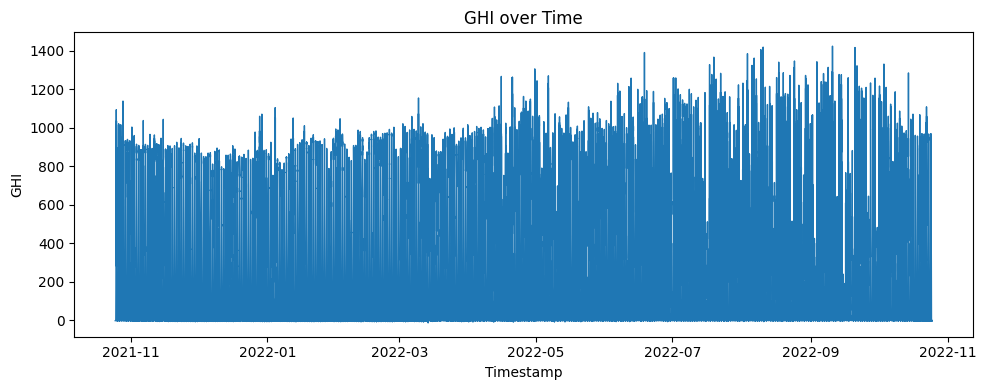

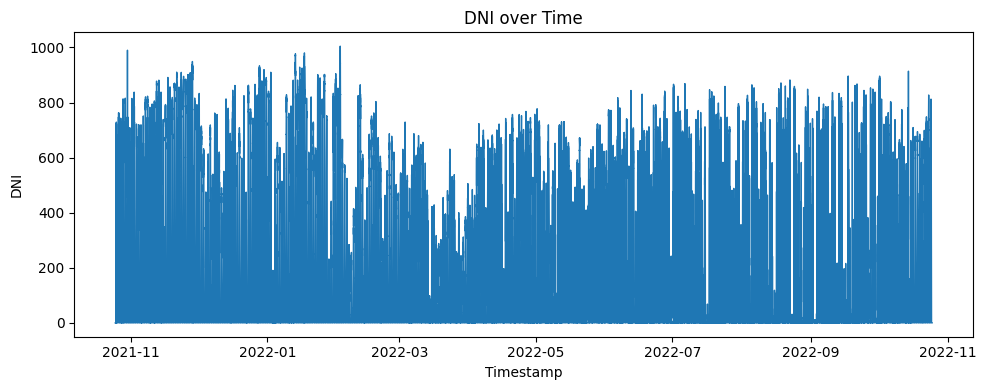

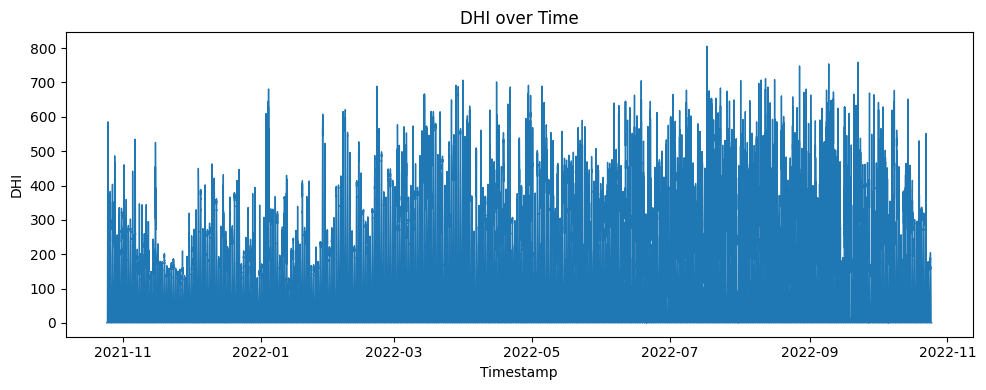

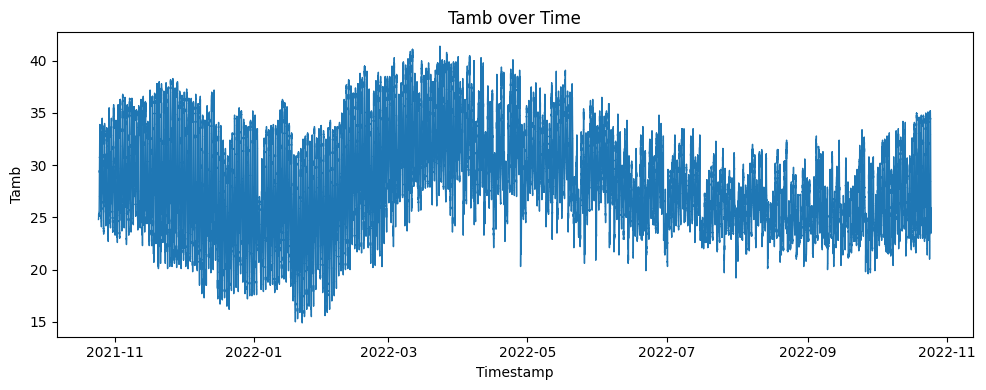

In [12]:
# Time-series line plots for selected variables
# We iterate over each variable in the list and generate a line plot over time.
# This helps visualize trends and patterns in the dataset over the given period.
for var in ["GHI", "DNI", "DHI", "Tamb"]:
    plt.figure(figsize=(10, 4))
    # Plot each variable against the Timestamp column
    plt.plot(df["Timestamp"], df[var], linewidth=1)
    plt.title(f"{var} over Time")  # Dynamic title using the variable name
    plt.xlabel("Timestamp")
    plt.ylabel(var)
    plt.tight_layout()  # Adjust plot layout to avoid clipping
    plt.show()  # Display the figure


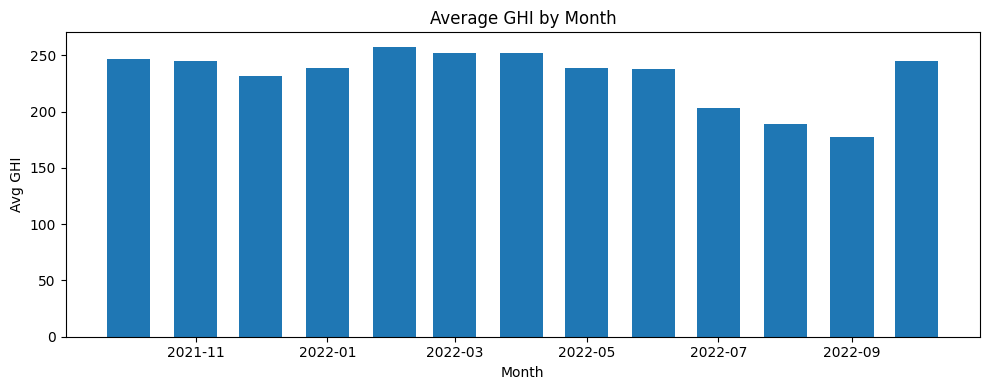

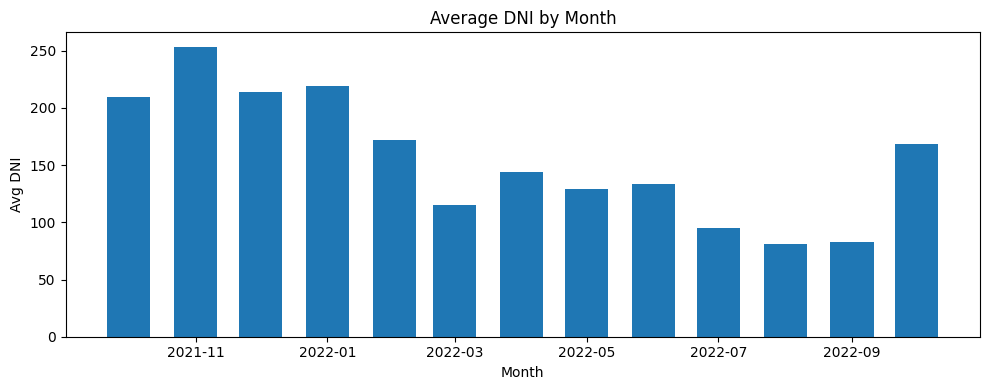

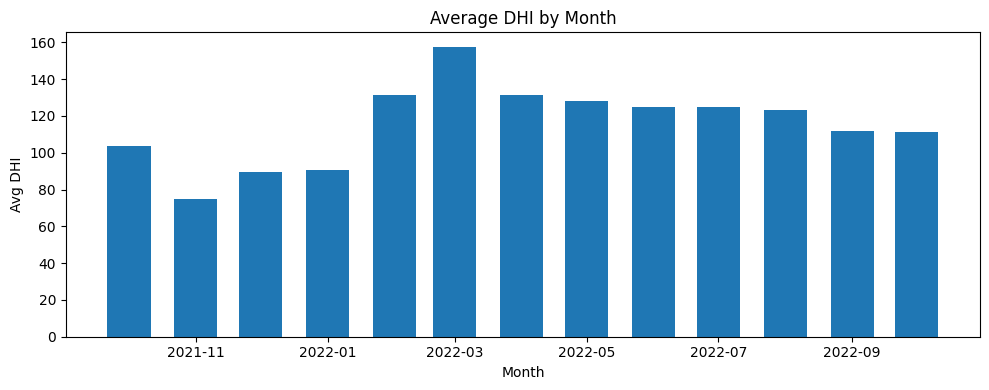

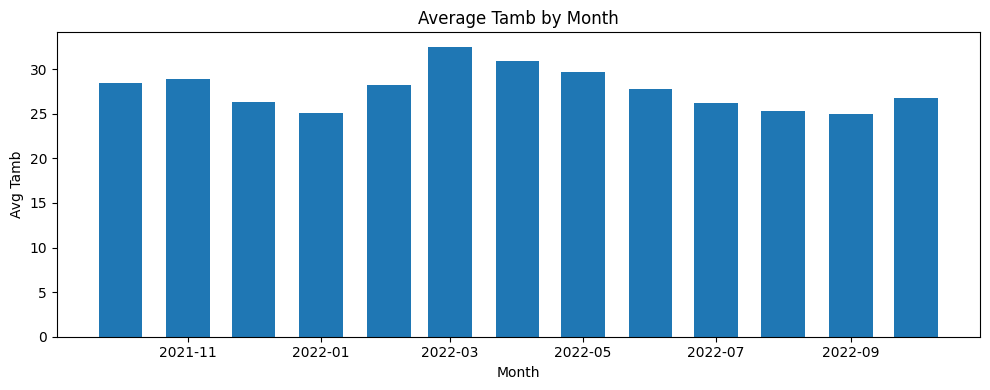

In [13]:
# Monthly averages bar charts
df["Month"] = df["Timestamp"].dt.to_period("M")
monthly_avg = df.groupby("Month")[["GHI", "DNI", "DHI", "Tamb"]].mean().reset_index()
monthly_avg["Month"] = monthly_avg["Month"].dt.to_timestamp()

for var in ["GHI", "DNI", "DHI", "Tamb"]:
    plt.figure(figsize=(10, 4))
    plt.bar(monthly_avg["Month"], monthly_avg[var], width=20)  # width in days
    plt.title(f"Average {var} by Month")
    plt.xlabel("Month")
    plt.ylabel(f"Avg {var}")
    plt.tight_layout()
    plt.show()


### Cleaning Impact


In [14]:
# Ensure 'Cleaning' is boolean

df["Cleaning"] = df["Cleaning"].astype(bool)


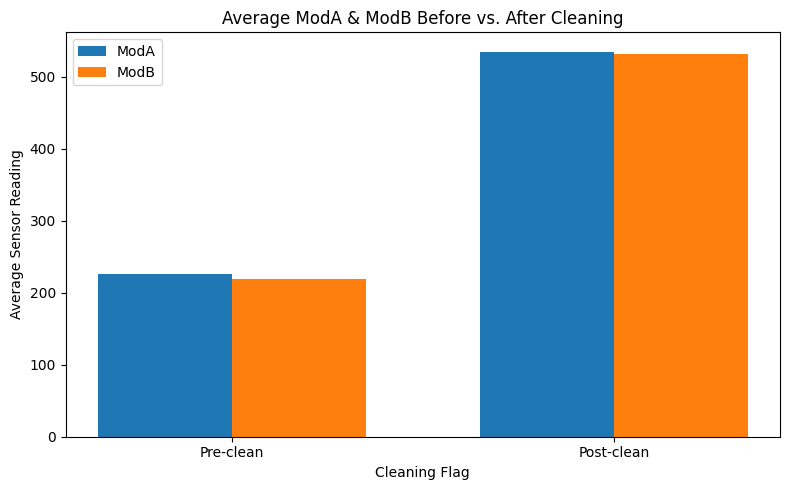

In [15]:
# Compute average ModA & ModB for Pre‐clean vs. Post‐clean states
grouped = (
    df
    .groupby("Cleaning")[["ModA", "ModB"]]
    .mean()
    .reset_index()
)

# Convert the boolean Cleaning column into labels for the chart
labels = grouped["Cleaning"].map({False: "Pre‐clean", True: "Post‐clean"})
x = range(len(labels))  # positions for the x‐axis
width = 0.35  # width for each bar

plt.figure(figsize=(8, 5))
# Plot bars for ModA
plt.bar(x, grouped["ModA"], width=width, label="ModA")
# Plot bars for ModB side by side
plt.bar([i + width for i in x], grouped["ModB"], width=width, label="ModB")

# Adjust tick positions to center labels
plt.xticks([i + width / 2 for i in x], labels)
plt.xlabel("Cleaning Flag")
plt.ylabel("Average Sensor Reading")
plt.title("Average ModA & ModB Before vs. After Cleaning")
plt.legend()
plt.tight_layout()
plt.show()


### Correlation & Relationship Analysis


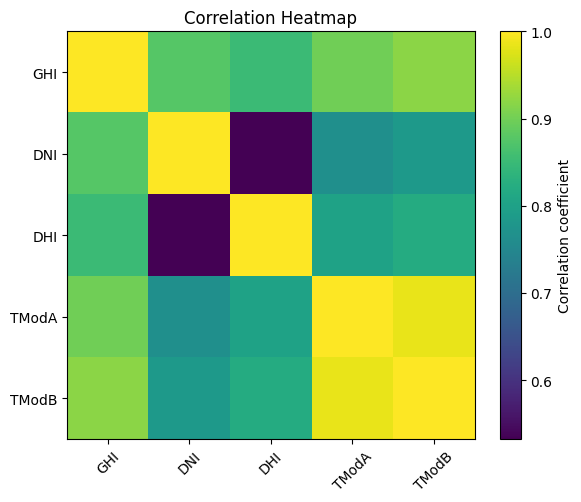

In [16]:

# Compute correlation matrix for GHI, DNI, DHI, TModA, TModB
corr_cols = ["GHI", "DNI", "DHI", "TModA", "TModB"]
corr_matrix = df[corr_cols].corr()

# Plot heatmap of correlations
plt.figure(figsize=(6, 5))
plt.imshow(corr_matrix, aspect='equal', interpolation='nearest')
plt.colorbar(label="Correlation coefficient")
plt.xticks(range(len(corr_cols)), corr_cols, rotation=45)
plt.yticks(range(len(corr_cols)), corr_cols)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


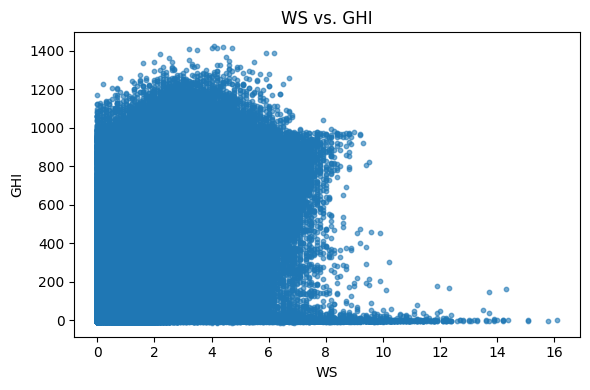

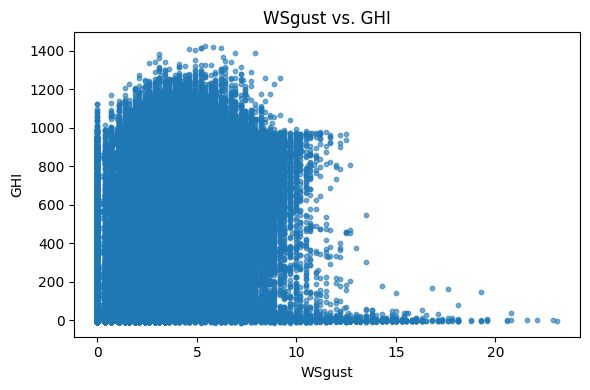

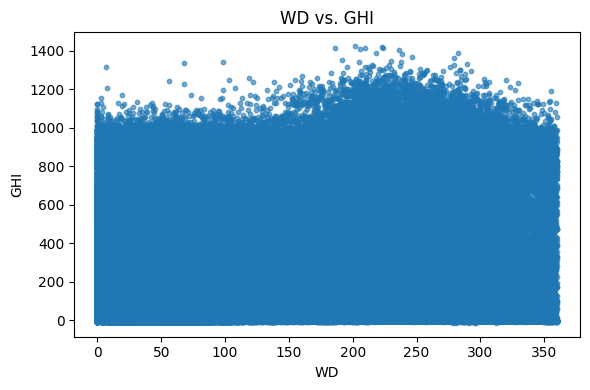

In [17]:
# Scatter plots of WS, WSgust, WD vs. GHI
for var in ["WS", "WSgust", "WD"]:
    plt.figure(figsize=(6, 4))
    plt.scatter(df[var], df["GHI"], s=10, alpha=0.6)
    plt.xlabel(var)
    plt.ylabel("GHI")
    plt.title(f"{var} vs. GHI")
    plt.tight_layout()
    plt.show()


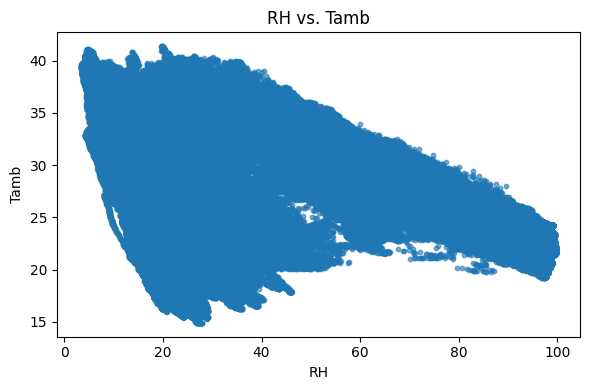

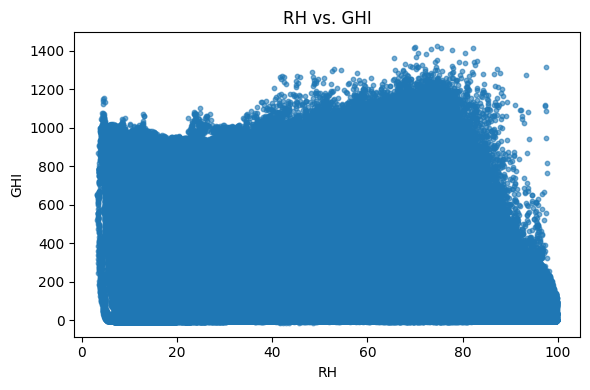

In [18]:
# 5. Scatter plots: Relationship between RH and Tamb, plus RH and GHI.
# We use scatter plots to visualize how changes in humidity (RH) might relate 
# to temperature (Tamb) and solar irradiance (GHI).

plt.figure(figsize=(6, 4))
# Plot RH on x‐axis against Tamb on y‐axis
plt.scatter(df["RH"], df["Tamb"], s=10, alpha=0.6)
plt.xlabel("RH")
plt.ylabel("Tamb")
plt.title("RH vs. Tamb")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
# Plot RH on x‐axis against GHI on y‐axis
plt.scatter(df["RH"], df["GHI"], s=10, alpha=0.6)
plt.xlabel("RH")
plt.ylabel("GHI")
plt.title("RH vs. GHI")
plt.tight_layout()
plt.show()


### Wind & Distribution Analysis


In [19]:
from windrose import WindroseAxes


/tmp/ipykernel_414066/968047779.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


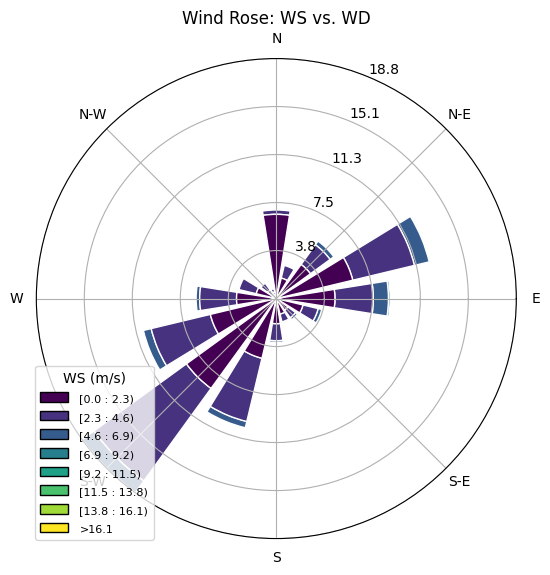

In [20]:
# Wind rose of Wind Speed (WS) and Wind Direction (WD)
fig = plt.figure(figsize=(6, 6))
ax = WindroseAxes.from_ax(fig=fig)
ax.bar(
    df["WD"],
    df["WS"],
    normed=True,
    opening=0.8,
    edgecolor="white",
    bins=8,            # number of speed bins
)
ax.set_legend(title="WS (m/s)")
ax.set_title("Wind Rose: WS vs. WD")
plt.tight_layout()
plt.show()


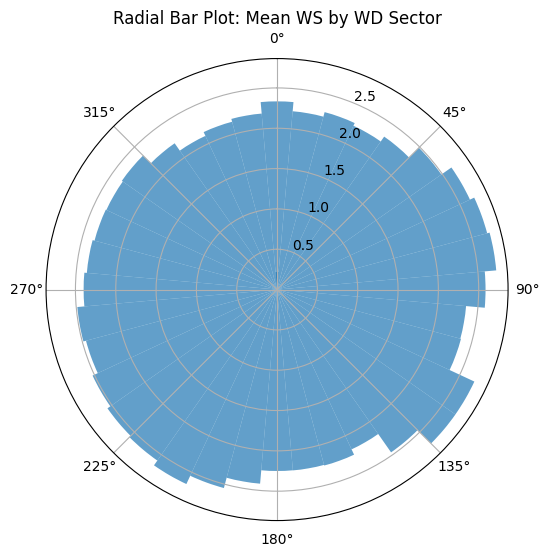

In [21]:
# Alternative radial bar plot (manual)
# Aggregate WS by WD sector
df["WD_bin"] = (df["WD"] // 10) * 10   # 10° sectors
sector_means = df.groupby("WD_bin")["WS"].mean()
angles = np.deg2rad(sector_means.index)
values = sector_means.values

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, polar=True)
bars = ax.bar(
    angles,
    values,
    width=np.deg2rad(10),
    bottom=0.0,
    alpha=0.7
)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_title("Radial Bar Plot: Mean WS by WD Sector")
plt.show()



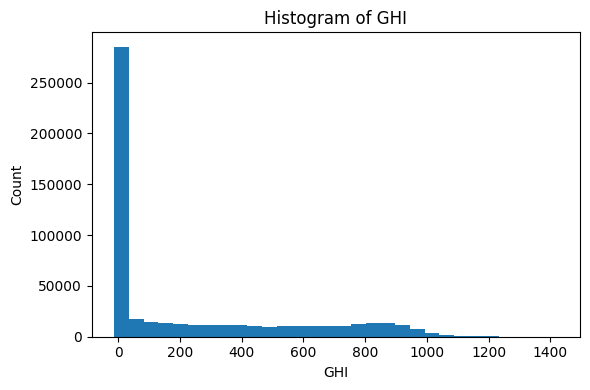

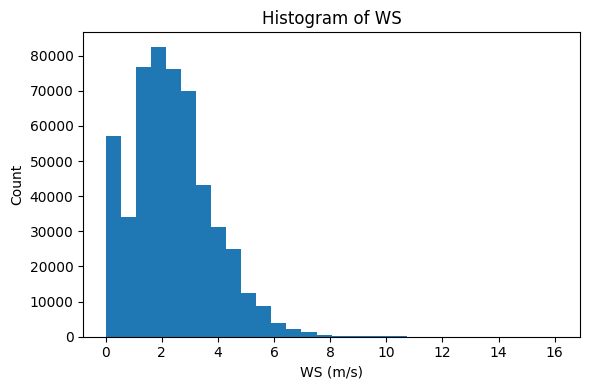

In [22]:
# Histograms of GHI and WS distributions
# Plot histogram of Global Horizontal Irradiance (GHI)
plt.figure(figsize=(6, 4))
plt.hist(df["GHI"].dropna(), bins=30)  # Use dropna() to ignore missing values
plt.title("Histogram of GHI")
plt.xlabel("GHI")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Plot histogram of Wind Speed (WS)
plt.figure(figsize=(6, 4))
plt.hist(df["WS"].dropna(), bins=30)  # Bins set to 30 for a clearer distribution view
plt.title("Histogram of WS")
plt.xlabel("WS (m/s)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


### Temperature Analysis


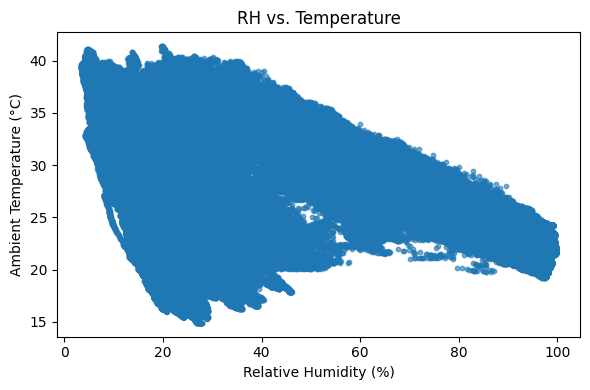

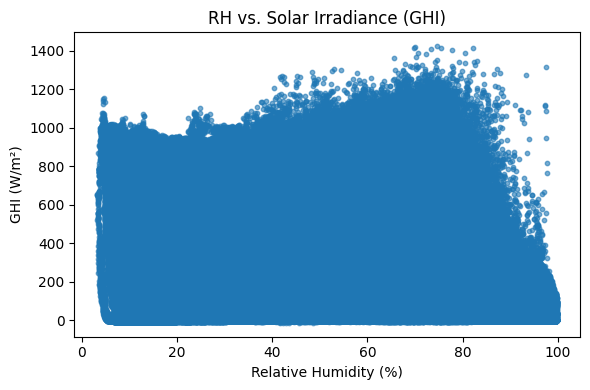

In [23]:
# Scatter plots examining the relationship between Relative Humidity and Temperature/Solar Irradiance

# Plot RH vs. Ambient Temperature
plt.figure(figsize=(6, 4))
# Each point shows one data record; size=10 indicates marker size, alpha=0.6 sets transparency
plt.scatter(df["RH"], df["Tamb"], s=10, alpha=0.6)
plt.xlabel("Relative Humidity (%)")
plt.ylabel("Ambient Temperature (°C)")
plt.title("RH vs. Temperature")
plt.tight_layout()
plt.show()

# Plot RH vs. GHI
plt.figure(figsize=(6, 4))
# Scatter plot helps visualize how changes in RH correspond to changes in solar irradiance (GHI)
plt.scatter(df["RH"], df["GHI"], s=10, alpha=0.6)
plt.xlabel("Relative Humidity (%)")
plt.ylabel("GHI (W/m²)")
plt.title("RH vs. Solar Irradiance (GHI)")
plt.tight_layout()
plt.show()


In [24]:
# Compute and print correlation coefficients
corr_temp = df[["RH", "Tamb"]].corr().iloc[0,1]
corr_ghi  = df[["RH", "GHI"]].corr().iloc[0,1]
print(f"Correlation RH–Tamb: {corr_temp:.3f}")
print(f"Correlation RH–GHI: {corr_ghi:.3f}")


Correlation RH–Tamb: -0.400
Correlation RH–GHI: -0.258


Row counts by RH bin:
      RH_bin  count
0    [0, 10)  19315
1   [10, 20)  74198
2   [20, 30)  55974
3   [30, 40)  37035
4   [40, 50)  35418
5   [50, 60)  44192
6   [60, 70)  57951
7   [70, 80)  64249
8   [80, 90)  67066
9  [90, 100)  70202


/tmp/ipykernel_414066/223081202.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_by_bin = df.groupby("RH_bin").size().reset_index(name="count")


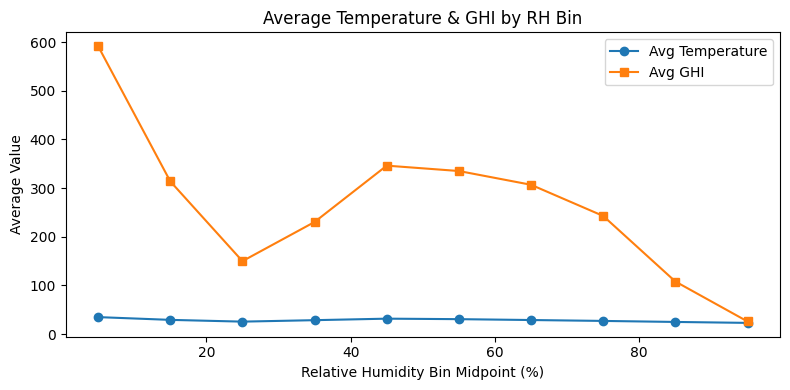

In [25]:
# Bin RH into categories and plot average temperature and GHI by RH bin
df["RH_bin"] = pd.cut(df["RH"], bins=np.arange(0, 110, 10), right=False)
binned = (
    df
    .groupby("RH_bin", observed=False)[["Tamb", "GHI"]]
    .mean()
    .reset_index()
)
# The code below provides a quick look at how many rows fall into each RH bin.
# This helps us understand the distribution of data points across humidity ranges.
counts_by_bin = df.groupby("RH_bin").size().reset_index(name="count")
print("Row counts by RH bin:")
print(counts_by_bin)
# Convert RH_bin to midpoint for plotting
binned["RH_mid"] = binned["RH_bin"].apply(lambda rng: rng.left + 5)

plt.figure(figsize=(8, 4))
plt.plot(binned["RH_mid"], binned["Tamb"], marker='o', label="Avg Temperature")
plt.plot(binned["RH_mid"], binned["GHI"], marker='s', label="Avg GHI")
plt.xlabel("Relative Humidity Bin Midpoint (%)")
plt.ylabel("Average Value")
plt.title("Average Temperature & GHI by RH Bin")
plt.legend()
plt.tight_layout()
plt.show()


### Bubble Chart



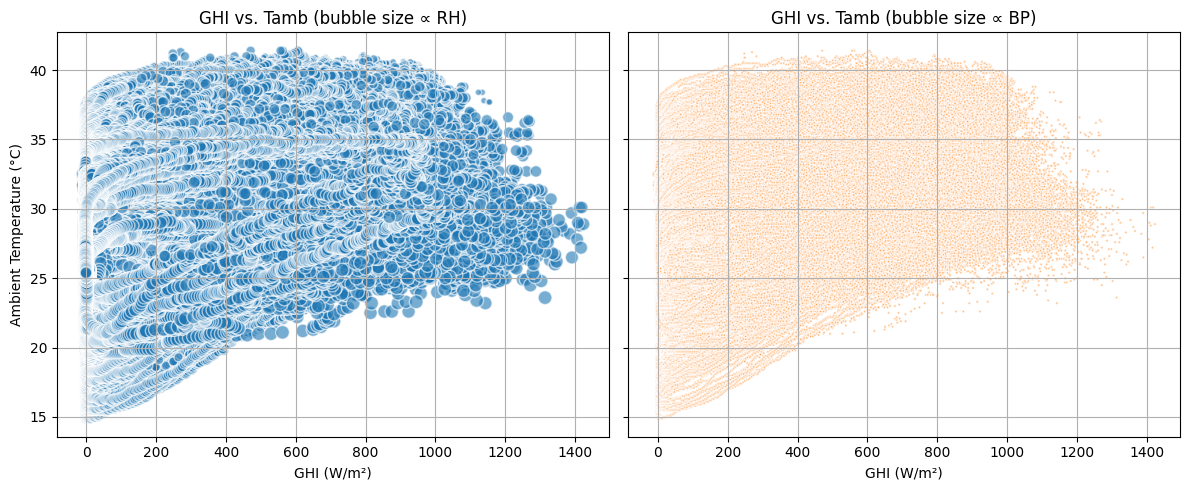

In [26]:
# Prepare data: drop rows with missing values in the chosen columns
df_bubble = df.dropna(subset=["GHI", "Tamb", "RH", "BP"])

# Scale bubble sizes (optional): e.g., square‐root scaling so sizes aren’t too large
size_rh = (df_bubble["RH"] ** 0.5) * 10    # RH‐based bubble
size_bp = (df_bubble["BP"] ** 0.5) * 0.1   # BP‐based bubble

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Bubble chart: GHI vs. Tamb, size = RH
axes[0].scatter(
    df_bubble["GHI"],
    df_bubble["Tamb"],
    s=size_rh,
    alpha=0.6,
    edgecolors='w'
)
axes[0].set_xlabel("GHI (W/m²)")
axes[0].set_ylabel("Ambient Temperature (°C)")
axes[0].set_title("GHI vs. Tamb (bubble size ∝ RH)")
axes[0].grid(True)

# Bubble chart: GHI vs. Tamb, size = BP
axes[1].scatter(
    df_bubble["GHI"],
    df_bubble["Tamb"],
    s=size_bp,
    alpha=0.6,
    edgecolors='w',
    color='C1'
)
axes[1].set_xlabel("GHI (W/m²)")
axes[1].set_title("GHI vs. Tamb (bubble size ∝ BP)")
axes[1].grid(True)

plt.tight_layout()
plt.show()
